# Circuit implementation of Order Finding and Shor's algorithm using Cirq

This notebook will teach you how to construct your own circuits for Order Finding and Shor's algorithm using Cirq.

# Install Cirq

Install Cirq if you haven't.

In [ ]:
!pip install --quiet cirq

# Importing packages

In [ ]:
import cirq # No need to explain why
import numpy as np # Need it for using pi
from fractions import Fraction # For carrying out continued fraction
import matplotlib.pyplot as plt # For plotting values of functions

# Order Finding algorithm

We start with the circuit of the Order Finding algorithm, which is the quantum subroutine in the famous Shor's algorithm. This algorithm is used to compute the order of the function $f(x) = a^{x} \text{ mod } N$, that is, an $r \in \mathbb{N}$ such that $f(r) = a^{r} \text{ mod }N = 1$. This can also be seen as finding the period of the periodic function $f$. The idea is to use Quantum Phase Estimation on the operator 

\begin{equation}
  U|x\rangle = |ax \text{ mod }N \rangle
\end{equation}

with $|1\rangle$ prepared in the register where usually an eigenvector is prepared. In our examples, we will be using $2$ qubits for precision and hence the circuit will look like this

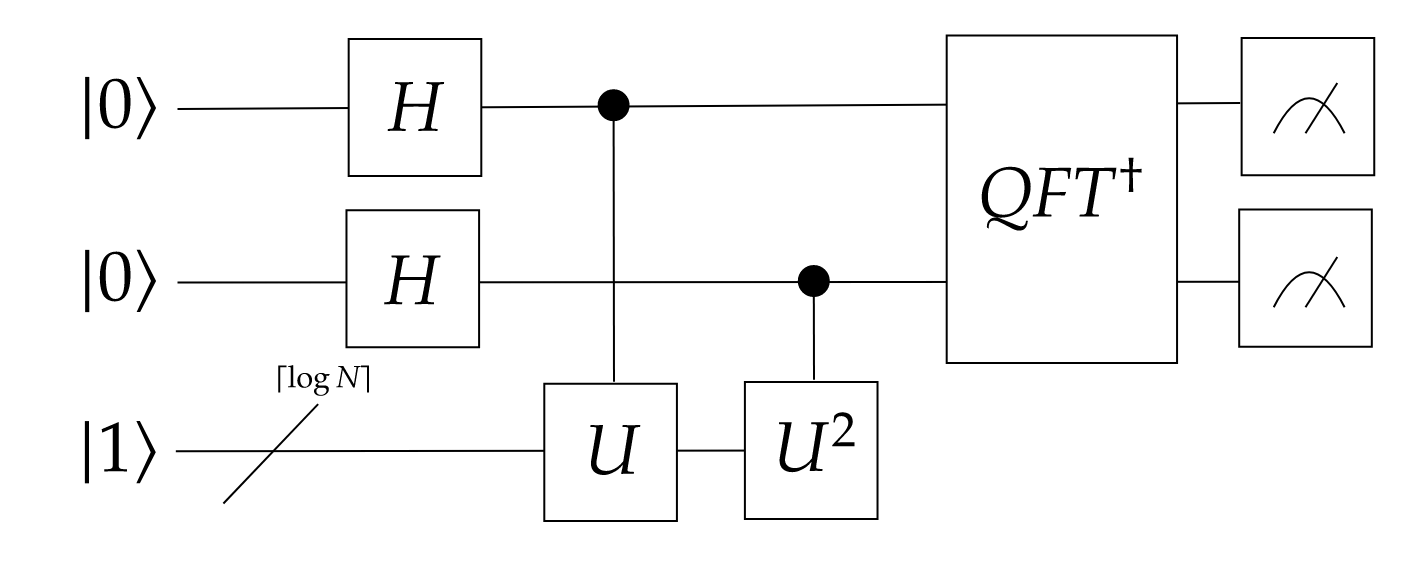

The measurement output gives us the value $\frac{s}{r}$. From this outout, we use continued fraction to get the value of $r$.

In this example, we will be carrying out Order finding for $a = 7$ and $N = 15$. So, we are going to compute the order of the function $f(x) = 7^x \text{ mod }15$. The circuit for the required unitary $U$ is

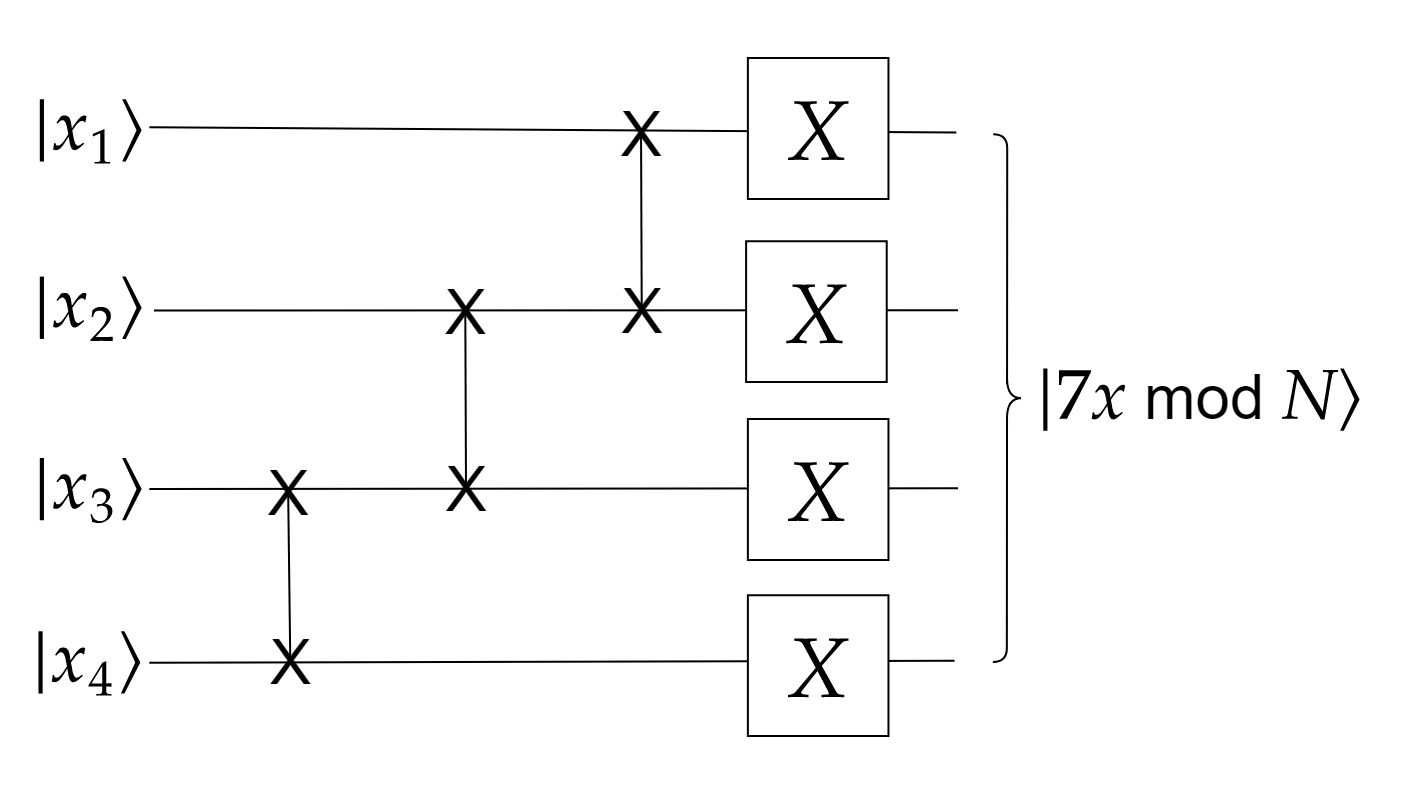

where $x = x_1 x_2 x_3 x_4$.



Note that this is not the kind of unitary that gives an algorithm which has complexity polynomial in $j$. To achieve that, one should simulate classical repeated squaring on a quantum computer, which is always possible. But, for demonstration purpose, we'll use this circuit. For more details regarding preparing oracles, we refer the reader to https://qiskit.org/textbook/ch-algorithms/shor.html. To apply this gate in a controlled manner, we replace each swap gate with controlled-swap gate and each $X$ gate by $CNOT$ gates, all controlled on the required control qubit.

Since $N = 15$, there are $15$ possible outputs to this function and hence $4$ qubits are required in the last register of the circuit. Therefore the final circuit that we have to simulate would look like this

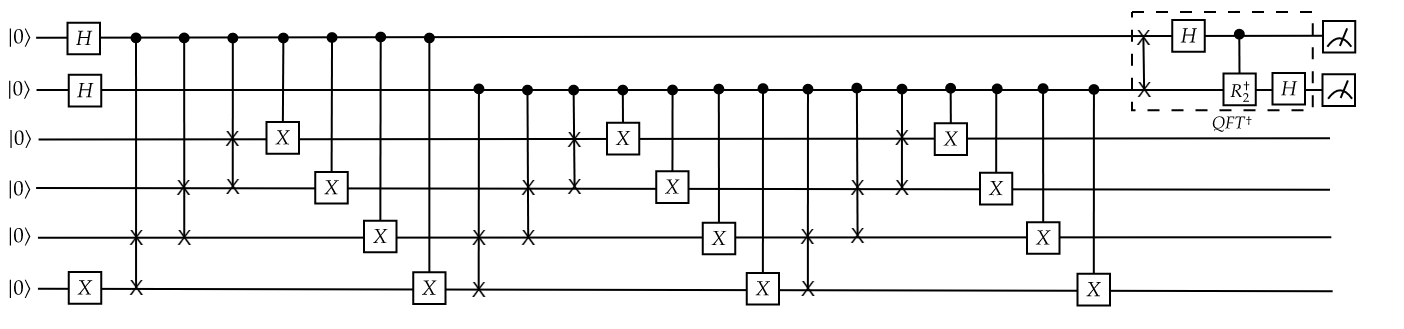

Now, we move on to constructing this circuit using Cirq.

First we initialze a circuit.

In [ ]:
# Prepare circuit 
circuit = cirq.Circuit()

The next step is to initialize the qubits. For this circuit, we require $6$ qubits. 

In [ ]:
# Prepare qubits
q_list = cirq.LineQubit.range(6)

Now, we shall start applying the gates.

Apply Hadamard gates on first $2$ qubits

In [ ]:
# Apply Hadamard gate on first 2 qubits
for i in range(2):
  circuit.append(cirq.H(q_list[i]))

Apply $X$ gate on the last qubit to prepare $|1\rangle$ on the second register.

In [ ]:
# Apply X gate on the last qubit
circuit.append(cirq.X(q_list[5]))

Now, we shall start applying controlled-$U ^ {2 ^ j}$ gates.

In [ ]:
# Apply controlled-U gates
for control_qubit in range(2):
  for k in range(2 ** control_qubit):
    circuit.append(cirq.ops.CSWAP(q_list[control_qubit],q_list[4],q_list[5]))
    circuit.append(cirq.ops.CSWAP(q_list[control_qubit],q_list[3],q_list[4]))
    circuit.append(cirq.ops.CSWAP(q_list[control_qubit],q_list[2],q_list[3]))

    for j in range(2,6):
      circuit.append(cirq.CNOT(q_list[control_qubit], q_list[j]))

Let's take a break and visualize the circuit.

In [ ]:
print(circuit)

0: ───H───@───@───@───@───@───@───@───────────────────────────────────────────────────────────
          │   │   │   │   │   │   │
1: ───H───┼───┼───┼───┼───┼───┼───┼───@───@───@───@───@───@───@───@───@───@───@───@───@───@───
          │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │
2: ───────┼───┼───×───X───┼───┼───┼───┼───┼───×───X───┼───┼───┼───┼───┼───×───X───┼───┼───┼───
          │   │   │       │   │   │   │   │   │       │   │   │   │   │   │       │   │   │
3: ───────┼───×───×───────X───┼───┼───┼───×───×───────X───┼───┼───┼───×───×───────X───┼───┼───
          │   │               │   │   │   │               │   │   │   │               │   │
4: ───────×───×───────────────X───┼───×───×───────────────X───┼───×───×───────────────X───┼───
          │                       │   │                       │   │                       │
5: ───X───×───────────────────────X───×───────────────────────X───×───────────────────────X───


Looks good. The next part is the inverse quantum Fourier transform part.

In [ ]:
# Apply swap gates
circuit.append(cirq.SWAP(q_list[0], q_list[1]))

# Apply controlled-Rk inverse gates
for target_qubit in range(2):
  for control_qubit in range(target_qubit):
    circuit.append(cirq.CZ(q_list[control_qubit], q_list[target_qubit])**(-1/(2 ** (target_qubit-control_qubit))))
  circuit.append(cirq.H(q_list[target_qubit]))

Let's look at the circuit once more before we move on to measurement.

In [ ]:
print(circuit)

0: ───H───@───@───@───@───@───@───@───────────────────────────────────────────────────────────×───H───@────────────
          │   │   │   │   │   │   │                                                           │       │
1: ───H───┼───┼───┼───┼───┼───┼───┼───@───@───@───@───@───@───@───@───@───@───@───@───@───@───×───────@^-0.5───H───
          │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │
2: ───────┼───┼───×───X───┼───┼───┼───┼───┼───×───X───┼───┼───┼───┼───┼───×───X───┼───┼───┼────────────────────────
          │   │   │       │   │   │   │   │   │       │   │   │   │   │   │       │   │   │
3: ───────┼───×───×───────X───┼───┼───┼───×───×───────X───┼───┼───┼───×───×───────X───┼───┼────────────────────────
          │   │               │   │   │   │               │   │   │   │               │   │
4: ───────×───×───────────────X───┼───×───×───────────────X───┼───×───×───────────────X───┼────────────────────────
          │                       │   │ 

Looks very good. Now, we shall measure, simulate the circuit $1000$ times and analyze the result.

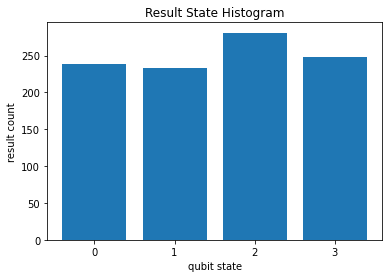

In [ ]:
# Measure
s=cirq.Simulator()
results=s.simulate(circuit, qubit_order = q_list)
circuit.append(cirq.measure(*list(reversed(q_list[:2])), key='result'))
samples=s.run(circuit, repetitions=1000)

# Plot the results
cirq.vis.plot_state_histogram(samples)

From the histogram, we can see that there are $4$ equally likely outputs. Let's convert these outputs to decimal values and carry out continued fraction on them.

In [ ]:
# Apply continued fraction on the output
for key in samples.histogram(key = 'result'):
  print(Fraction(key/4))

0
1/2
1/4
3/4


We can see that possible values are $4$ and $2$. Since $4$ occurred the most, we go with $4$. To verify if $4$ is indeed the period of our function, we shall plot $f$ on a graph

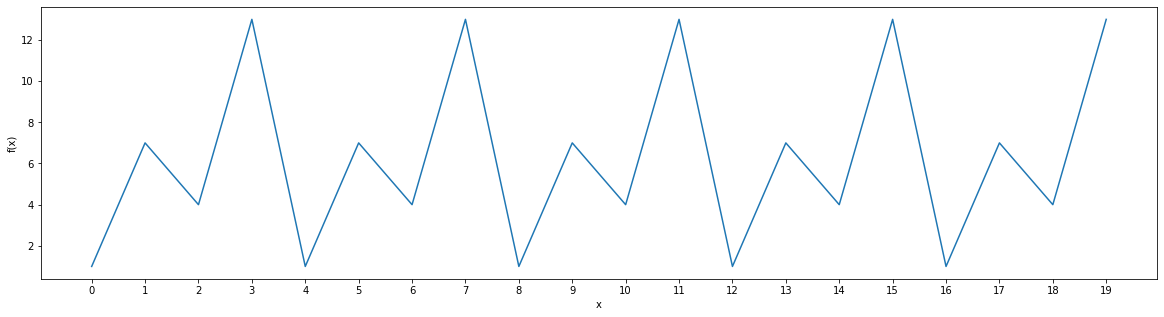

In [ ]:
# Plot f
x = list(range(20))
y = [(7 ** k) % 15 for k in x]
f =plt.figure()
plt.plot(x, y)
f.set_figwidth(20)
f.set_figheight(5)
plt.xticks(x)
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

From the graph, it is evident that $4$ is indeed the period of the function $f$.

The final circuit is

In [ ]:
print(circuit)

0: ───H───@───@───@───@───@───@───@───────────────────────────────────────────────────────────×───H───@────────────M─────────────
          │   │   │   │   │   │   │                                                           │       │            │
1: ───H───┼───┼───┼───┼───┼───┼───┼───@───@───@───@───@───@───@───@───@───@───@───@───@───@───×───────@^-0.5───H───M('result')───
          │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │   │
2: ───────┼───┼───×───X───┼───┼───┼───┼───┼───×───X───┼───┼───┼───┼───┼───×───X───┼───┼───┼──────────────────────────────────────
          │   │   │       │   │   │   │   │   │       │   │   │   │   │   │       │   │   │
3: ───────┼───×───×───────X───┼───┼───┼───×───×───────X───┼───┼───┼───×───×───────X───┼───┼──────────────────────────────────────
          │   │               │   │   │   │               │   │   │   │               │   │
4: ───────×───×───────────────X───┼───×───×───────────────X───┼───×───×───────────────X

# Shor's algorithm for factoring

In this section, we shall implement Shor's algorithm to factorize the number $15$. Shor's algorithm can be used to compute a prime factor of any number $N$.

1. Check if a prime factor of $N$ can be easily computed. (Prime number, power of prime number, even number)
2. If not, randomly choose a number $a$ from $1, \dots, N$. If $\text{gcd}(a,N) > 1$, return $a$.
3. Use quantum order finding algorithm to find $r$ such that $a^r \text{ mod } N = 1$,
4. If $r$ is even and $a ^ {\frac{r}{2}} \text{ mod } N \neq N - 1$, then compute $\text{gcd}(a ^{\frac{r}{2}}-1,N)$ and $\text{gcd}(a ^{\frac{r}{2}}+1,N)$.
5. If anyone of them is a non-trivial factor of $N$, then return it, otherwise abort.

Since $15$ is not elligible for any of the available classical algorithms, we can move past Step 1. Since we have already carried out order finding for $a =7$ and $N = 15$, we shall choose $7$ in Step $2$. We have already found the order to be $4$. Now, we shall carry out Step $4$. Since $7^2 \text{ mod }N = 4 \neq 14$, we can compute the required gcds. 

In [ ]:
# Compute gcd(48,15)
x = 48
y = 15
while y:
  x, y = y, x % y

print("gcd of 48 and 15 is: {}".format(x))

gcd of 48 and 15 is: 3


$3$ is a prime factor of $15$. When we divide $15$ by $3$, we get the other prime factor $5$.